## 1. Introduction
#### In this notebook, we explore the PM2.5 dataset using a combination of summary statistics and residual-based methods to detect anomalies and better understand the distribution of air pollution levels across various countries and demographic groups. This comprehensive approach helps uncover hidden patterns and identify data points that deviate significantly from expected trends.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Import the dataset
df = pd.read_csv("../data/processed/pm25_cleaned.csv")

In [4]:
# drop useless columns
df = df.drop(columns=["Period type", "Dim1 type", "Location type", "Dim1ValueCode", "IndicatorCode", "Indicator", "ParentLocationCode", "ValueType"])

## 2. Summary Statistics
#### To build a foundational understanding of the data, we performed a series of summary statistical analyses focusing on the FactValueNumeric variable, which represents PM2.5 levels. This included:

- #### Descriptive Statistics: Calculation of central tendency and dispersion metrics such as the mean, median, standard deviation, minimum, and maximum PM2.5 values.
- #### Distribution Analysis: Examination of PM2.5 levels across different geographic and demographic dimensions to determine which regions or categories consistently exhibit high or low pollution levels.

In [5]:
# Summary stats for all PM2.5 values
df['FactValueNumeric'].describe()

count    9169.000000
mean       22.229568
std        13.174273
min         4.590000
25%        11.660000
50%        19.050000
75%        29.260000
max        59.560000
Name: FactValueNumeric, dtype: float64

In [6]:
# Summary by year
year_summary = df.groupby('Period')['FactValueNumeric'].agg(['mean', 'median', 'min', 'max', 'std']).round(2)
year_summary

,mean,median,min,max,std
Period,,,,,
2010,22.79,20.52,4.65,58.95,12.80
2011,22.96,20.44,4.59,59.45,13.28
2012,22.66,19.62,4.93,59.56,13.42
2013,22.15,19.49,4.75,59.05,12.82
2014,22.17,19.12,4.98,59.30,13.11
2015,22.29,18.87,4.97,59.52,13.35
2016,22.22,18.67,4.93,59.20,13.44
2017,21.94,18.42,4.94,59.39,13.26
2018,21.87,18.47,5.13,59.51,13.23


In [8]:
# Summary by country
country_summary = df.groupby('Location')['FactValueNumeric'].agg(['mean', 'median', 'min', 'max', 'std']).round(2)
country_summary

,mean,median,min,max,std
Location,,,,,
Afghanistan,56.03,56.00,55.08,57.00,0.96
Albania,19.85,19.40,15.65,23.41,1.95
Algeria,22.34,22.49,20.20,24.13,0.94
Andorra,9.96,9.71,7.96,12.13,1.11
Angola,26.60,26.30,22.37,33.19,2.89
...,...,...,...,...,...
Viet Nam,21.24,21.47,16.97,25.18,2.13
Yemen,41.19,41.28,37.00,44.60,1.75
Zambia,18.01,17.58,16.10,20.07,1.23


In [9]:
# Top 10 most polluted countries
top10_polluted = country_summary.sort_values(by='mean', ascending=False).head(10)
top10_polluted

,mean,median,min,max,std
Location,,,,,
Kuwait,56.87,56.72,52.82,59.02,1.60
Qatar,56.55,56.50,51.92,59.30,2.06
Saudi Arabia,56.48,56.69,51.98,58.60,1.63
Cameroon,56.22,57.01,50.83,59.56,2.55
Tajikistan,56.20,56.38,50.58,59.39,2.91
Afghanistan,56.03,56.00,55.08,57.00,0.96
Pakistan,55.26,55.82,48.52,59.51,2.72
Nigeria,55.04,55.10,51.15,58.56,1.96
Bahrain,54.22,54.40,49.32,59.45,2.34


In [10]:
# Top 10 cleanest countries
bottom10_polluted = country_summary.sort_values(by='mean', ascending=True).head(10)
bottom10_polluted

,mean,median,min,max,std
Location,,,,,
Bahamas,5.30,5.28,4.59,6.17,0.35
Finland,6.49,6.40,4.93,8.74,0.97
Niue,6.55,6.52,6.34,6.75,0.15
Iceland,6.58,6.46,5.47,8.49,0.71
Sweden,6.70,6.62,5.24,8.89,0.88
Tuvalu,6.84,6.83,6.70,6.95,0.08
Nauru,6.93,7.37,5.32,7.59,0.85
Canada,7.04,7.12,5.06,8.57,0.87
Estonia,7.14,7.02,5.40,8.89,0.88


In [11]:
# Summary by region
region_summary = df.groupby('ParentLocation')['FactValueNumeric'].agg(['mean', 'median', 'min', 'max', 'std']).round(2)
region_summary

,mean,median,min,max,std
ParentLocation,,,,,
Africa,29.40,29.05,9.77,59.56,12.46
Americas,14.65,12.84,4.59,34.66,6.57
Eastern Mediterranean,33.26,29.23,12.32,59.51,13.36
Europe,18.41,15.70,4.93,59.39,10.51
South-East Asia,30.81,26.17,11.68,59.07,13.47
Western Pacific,14.73,8.45,5.32,59.52,11.26


In [12]:
# Summary by area type 
area_summary = df.groupby('Dim1')['FactValueNumeric'].agg(['mean', 'median', 'min', 'max', 'std']).round(2)
area_summary

,mean,median,min,max,std
Dim1,,,,,
Cities,24.40,21.34,4.59,59.53,13.29
Rural,20.94,17.52,4.92,59.13,12.89
Total,21.63,18.47,4.92,59.39,12.95
Towns,21.91,18.49,5.22,59.45,13.09
Urban,22.58,19.12,4.92,59.56,13.44


In [13]:
guideline = 22  # mean guideline (µg/m³)

above_guideline = df[df['FactValueNumeric'] > guideline]
pct_above = len(above_guideline) / len(df) * 100

print("\nGuideline Benchmarking:")
print(f"- annual guideline: {guideline} µg/m³")
print(f"- Observations above guideline: {len(above_guideline)} ({pct_above:.1f}%)")
print(f"- Highest value: {df['FactValueNumeric'].max():.1f} µg/m³")
print(f"- Lowest value: {df['FactValueNumeric'].min():.1f} µg/m³")

# By region
print("\nPercentage above guideline by region:")
display(above_guideline.groupby('ParentLocation').size() / df.groupby('ParentLocation').size() * 100)


Guideline Benchmarking:
- annual guideline: 22 µg/m³
- Observations above guideline: 3835 (41.8%)
- Highest value: 59.6 µg/m³
- Lowest value: 4.6 µg/m³

Percentage above guideline by region:


ParentLocation
Africa                   65.815664
Americas                 16.508876
Eastern Mediterranean    82.814178
Europe                   26.017214
South-East Asia          68.918919
Western Pacific          20.808255
dtype: float64

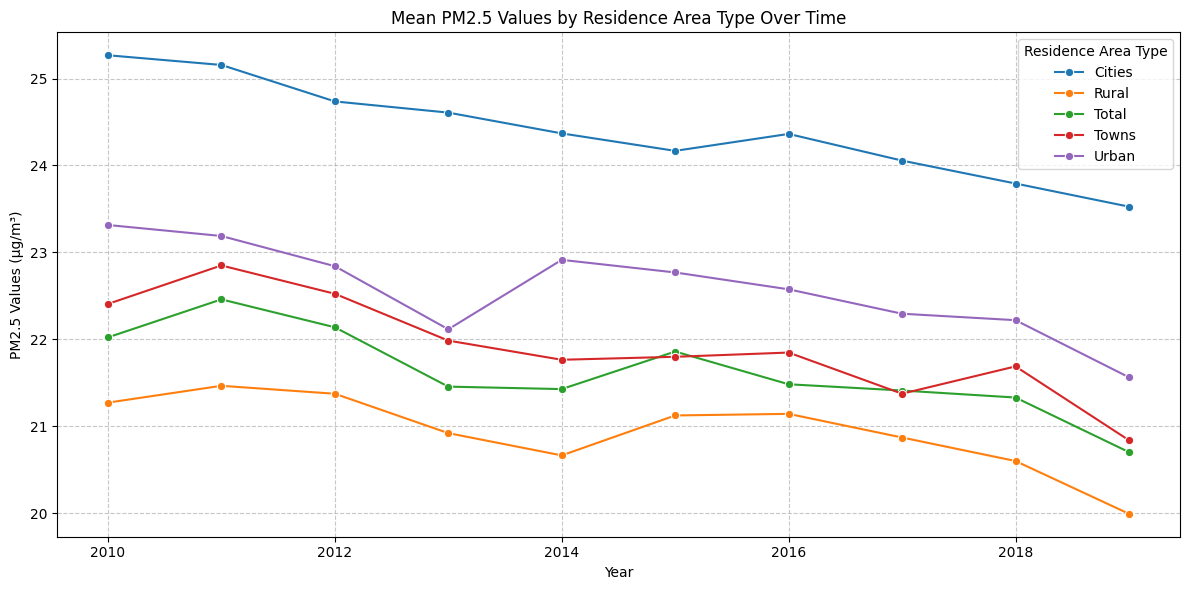

In [14]:
# Group by Dim1 and Period, calculate mean PM2.5 values
dim1_period_summary = df.groupby(['Dim1', 'Period'])['FactValueNumeric'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=dim1_period_summary, x='Period', y='FactValueNumeric', hue='Dim1', marker='o')
plt.xlabel('Year')
plt.ylabel('PM2.5 Values (µg/m³)')
plt.title('Mean PM2.5 Values by Residence Area Type Over Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Residence Area Type')
plt.tight_layout()
plt.show()

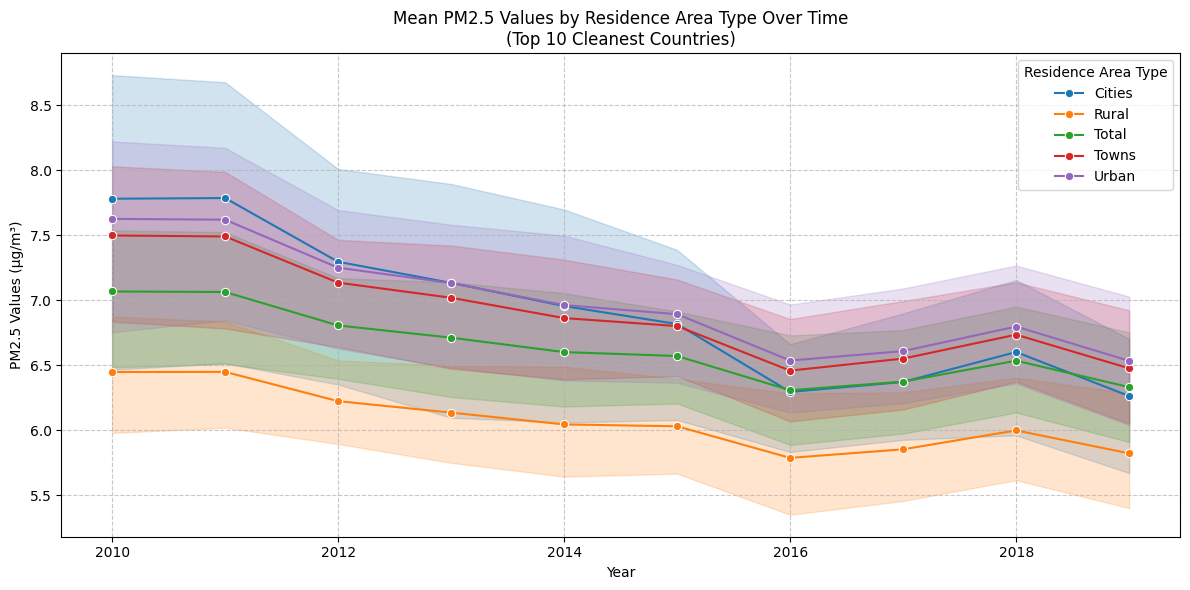


Top 10 Cleanest Countries:
Bahamas
Finland
Niue
Iceland
Sweden
Tuvalu
Nauru
Canada
Estonia
Marshall Islands


In [33]:
# First identify the top 10 cleanest countries based on their mean PM2.5 values
cleanest_countries = df.groupby('Location')['FactValueNumeric'].mean().sort_values().head(10).index

# Filter the data for these countries
clean_countries_df = df[df['Location'].isin(cleanest_countries)]

# Group by Dim1 and Period for these countries
dim1_period_summary = clean_countries_df.groupby(['Dim1', 'Period', 'Location'])['FactValueNumeric'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=dim1_period_summary, x='Period', y='FactValueNumeric', hue='Dim1', marker='o')
plt.xlabel('Year')
plt.ylabel('PM2.5 Values (µg/m³)')
plt.title('Mean PM2.5 Values by Residence Area Type Over Time\n(Top 10 Cleanest Countries)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Residence Area Type')
plt.tight_layout()
plt.show()

# Print the list of cleanest countries for reference
print("\nTop 10 Cleanest Countries:")
for country in cleanest_countries:
    print(country)

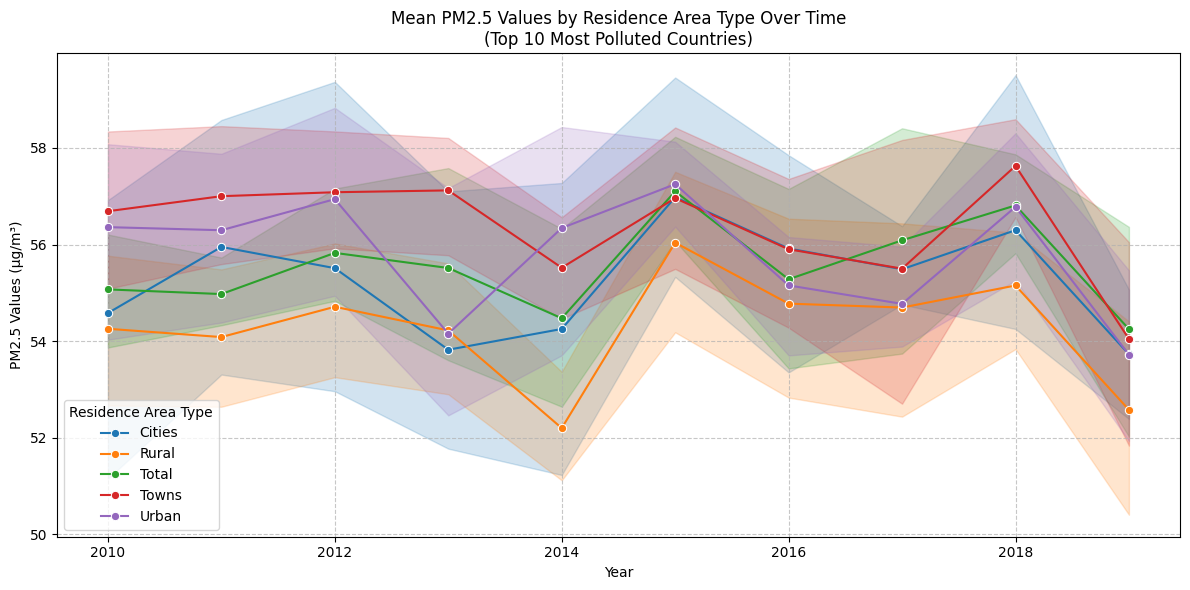


Top 10 Most Polluted Countries:
Kuwait
Qatar
Saudi Arabia
Cameroon
Tajikistan
Afghanistan
Pakistan
Nigeria
Bahrain
India


In [34]:
# First identify the top 10 most polluted countries based on their mean PM2.5 values
polluted_countries = df.groupby('Location')['FactValueNumeric'].mean().sort_values(ascending=False).head(10).index

# Filter the data for these countries
polluted_countries_df = df[df['Location'].isin(polluted_countries)]

# Group by Dim1 and Period for these countries
dim1_period_summary = polluted_countries_df.groupby(['Dim1', 'Period', 'Location'])['FactValueNumeric'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=dim1_period_summary, x='Period', y='FactValueNumeric', hue='Dim1', marker='o')
plt.xlabel('Year')
plt.ylabel('PM2.5 Values (µg/m³)')
plt.title('Mean PM2.5 Values by Residence Area Type Over Time\n(Top 10 Most Polluted Countries)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Residence Area Type')
plt.tight_layout()
plt.show()

# Print the list of most polluted countries for reference
print("\nTop 10 Most Polluted Countries:")
for country in polluted_countries:
    print(country)

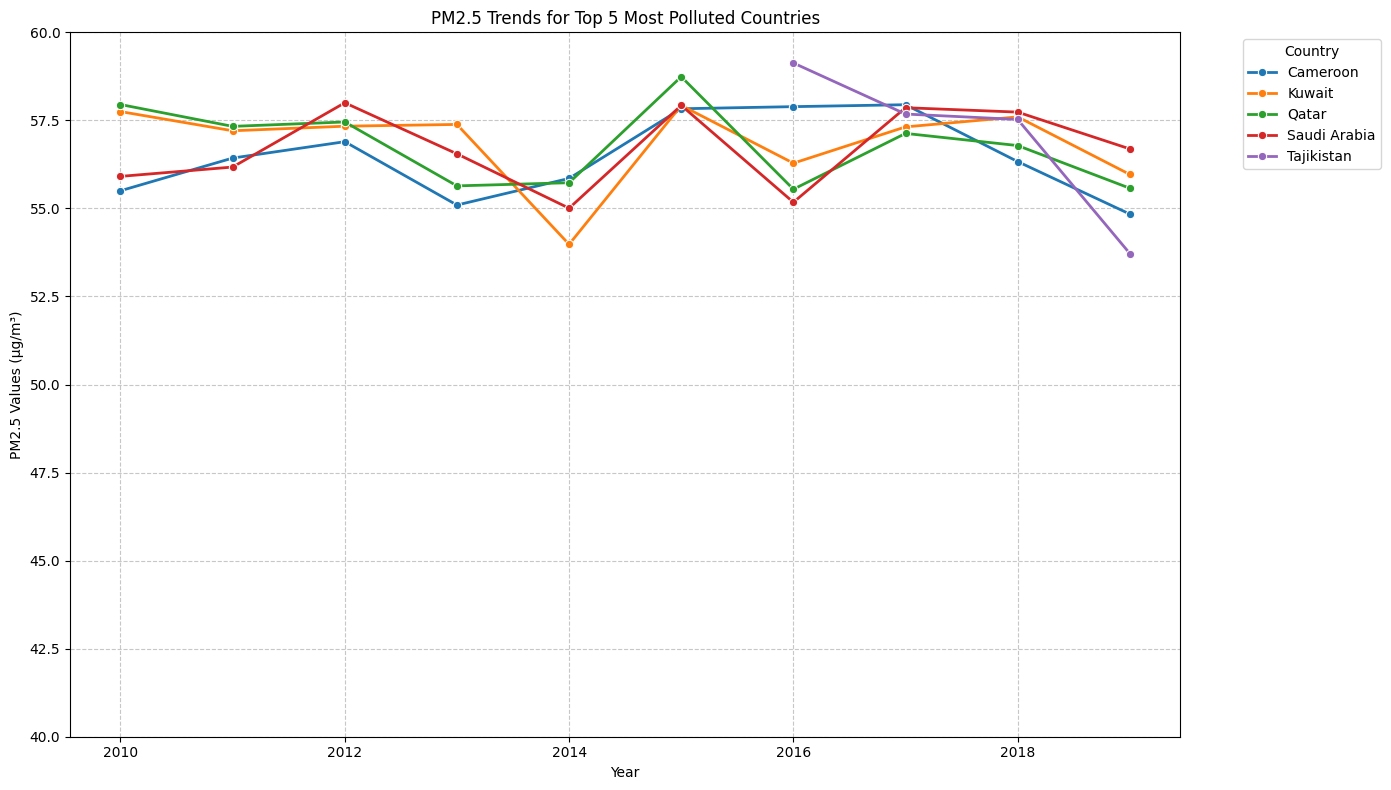

In [27]:
# Get the top 5 most polluted countries
top5_countries = df.groupby('Location')['FactValueNumeric'].mean().sort_values(ascending=False).head(5).index

# Filter the data for these countries
top5_data = df[df['Location'].isin(top5_countries)]

# Group by Location and Period, calculate mean PM2.5 values
top5_period_summary = top5_data.groupby(['Location', 'Period'])['FactValueNumeric'].mean().reset_index()

# Create the plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=top5_period_summary, x='Period', y='FactValueNumeric', hue='Location', marker='o', linewidth=2)
plt.xlabel('Year')
plt.ylabel('PM2.5 Values (µg/m³)')
plt.title('PM2.5 Trends for Top 5 Most Polluted Countries')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(40, 60)  # Set y-axis limits from 0 to 70
plt.tight_layout()
plt.show()

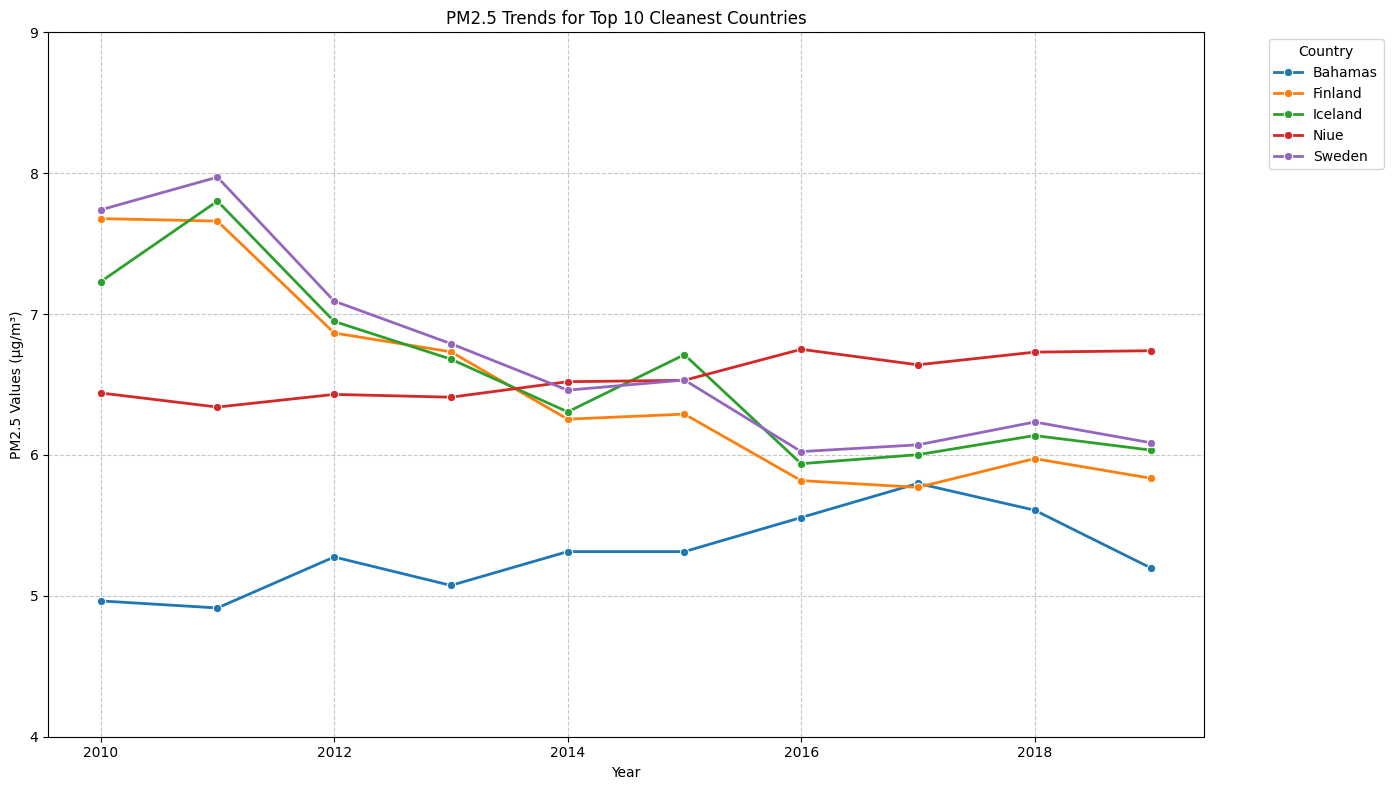

In [24]:
# Get the top 5 cleanest countries (lowest PM2.5)
top5_cleanest = df.groupby('Location')['FactValueNumeric'].mean().sort_values().head(5).index

# Filter the data for these countries
cleanest_data = df[df['Location'].isin(top5_cleanest)]

# Group by Location and Period, calculate mean PM2.5 values
cleanest_period_summary = cleanest_data.groupby(['Location', 'Period'])['FactValueNumeric'].mean().reset_index()

# Create the plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=cleanest_period_summary, x='Period', y='FactValueNumeric', hue='Location', marker='o', linewidth=2)
plt.xlabel('Year')
plt.ylabel('PM2.5 Values (µg/m³)')
plt.title('PM2.5 Trends for Top 5 Cleanest Countries')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(4, 9)  # Set y-axis limits from 0 to 70
plt.tight_layout()
plt.show()

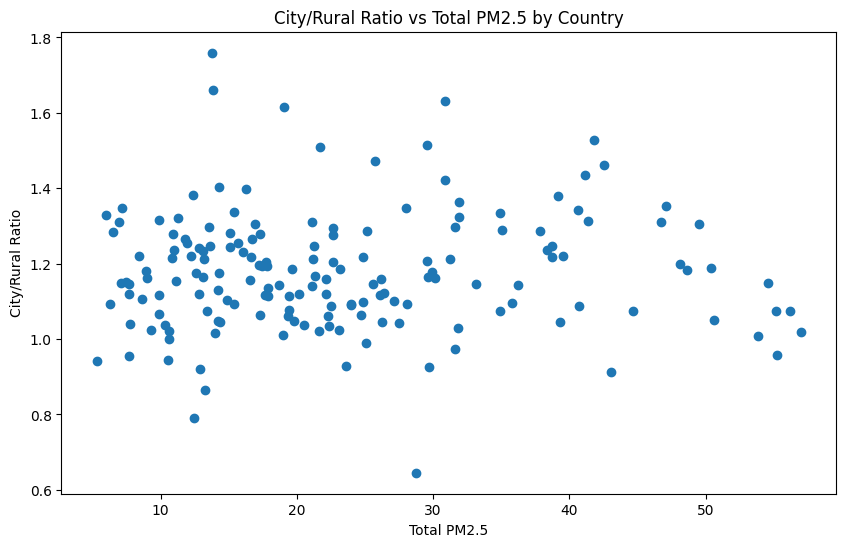

In [32]:
# Calculate PM2.5 for each type (Cities, Rural, Total)
city_pm25 = df[df['Dim1'] == 'Cities'].groupby('Location')['FactValueNumeric'].mean().reset_index()
rural_pm25 = df[df['Dim1'] == 'Rural'].groupby('Location')['FactValueNumeric'].mean().reset_index()
total_pm25 = df[df['Dim1'] == 'Total'].groupby('Location')['FactValueNumeric'].mean().reset_index()

# Merge the data
merged_data = pd.merge(city_pm25, rural_pm25, on='Location', suffixes=('_city', '_rural'))
merged_data = pd.merge(merged_data, total_pm25, on='Location')

# Calculate the ratio
merged_data['City_Rural_Ratio'] = merged_data['FactValueNumeric_city'] / merged_data['FactValueNumeric_rural']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['FactValueNumeric'], merged_data['City_Rural_Ratio'])
plt.xlabel('Total PM2.5')
plt.ylabel('City/Rural Ratio')
plt.title('City/Rural Ratio vs Total PM2.5 by Country')

# # Add country labels
# for i, txt in enumerate(merged_data['Location']):
#     plt.annotate(txt, (merged_data['FactValueNumeric'].iloc[i], merged_data['City_Rural_Ratio'].iloc[i]))

plt.show()

## 3. Residual Analysis
#### To further investigate unusual patterns in the data, we fitted an Ordinary Least Squares (OLS) regression model using ParentLocation and Dim1 as predictors of PM2.5 levels. Residuals—defined as the difference between actual and predicted PM2.5 values—were then analyzed to identify anomalous observations. This residual-based approach provides two key benefits:

- #### Detection of Irregularities: Residuals reveal data points that deviate significantly from the model’s expectations, indicating possible outliers.

- #### Contextual Insight: It highlights country- or category-specific deviations that may not be captured by global summary statistics alone.

#### Boxplots and IQR-based techniques were used to flag outliers in the residuals, offering a systematic way to identify unusual patterns and potential anomalies.

In [14]:
# Step 1: One-hot encode categorical variables (and ensure dtype is float)
X = pd.get_dummies(df[['Dim1', 'ParentLocation']], drop_first=True).astype(float)

# Step 2: Define target variable
y = df['FactValueNumeric'].astype(float)

# Step 3: Add constant to the predictors
X = sm.add_constant(X)

# Step 4: Fit the linear regression model
model = sm.OLS(y, X).fit()

# Step 5: Print the summary of the model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       FactValueNumeric   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     438.7
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        12:01:09   Log-Likelihood:                -35006.
No. Observations:                9169   AIC:                         7.003e+04
Df Residuals:                    9159   BIC:                         7.010e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


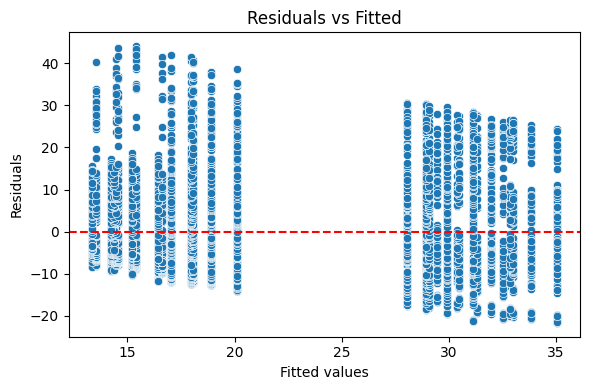

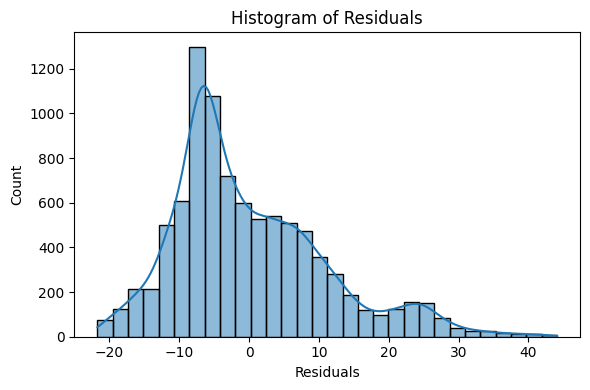

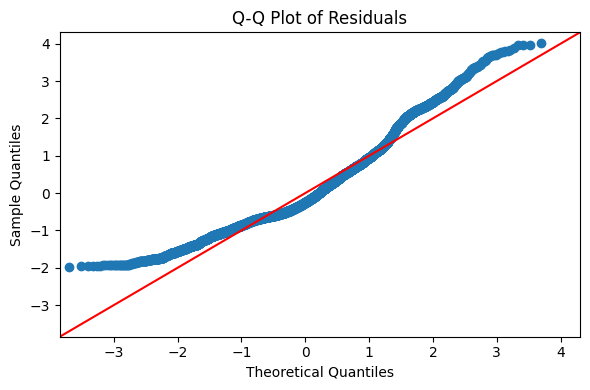

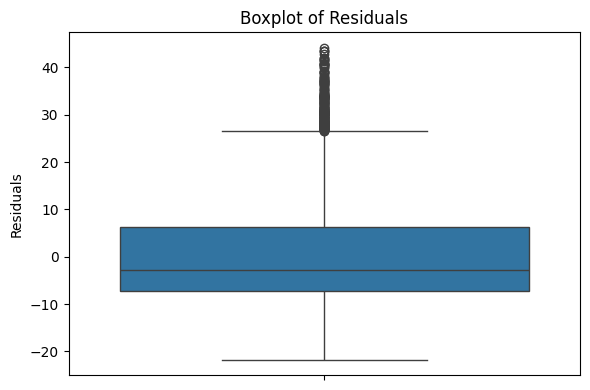

In [13]:
# Predicted values and residuals
fitted_vals = model.fittedvalues
residuals = model.resid

# 1. Residuals vs Fitted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.tight_layout()
plt.show()

# 2. Histogram of Residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.show()

# 3. Q-Q Plot
fig, ax = plt.subplots(figsize=(6, 4))
sm.qqplot(residuals, line='45', fit=True, ax=ax)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

# Boxplot of residuals
plt.figure(figsize=(6, 4))
sns.boxplot(y=residuals)
plt.title("Boxplot of Residuals")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

In [14]:
resid_df = pd.DataFrame({'Residuals': residuals})

# Calculate Q1, Q3, and IQR
Q1 = resid_df['Residuals'].quantile(0.25)
Q3 = resid_df['Residuals'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [15]:
outliers = resid_df[(resid_df['Residuals'] < lower_bound) | (resid_df['Residuals'] > upper_bound)]

# Display outliers
outliers

,Residuals
632,26.848451
634,26.844198
695,33.530501
696,35.207233
709,35.700701
...,...
9000,42.027233
9001,28.994111
9002,27.108985
9004,27.046708


## 4. Conclusion
#### By combining summary statistics with residual analysis, this notebook provides a well-rounded examination of PM2.5 levels in 2019. While summary statistics offer a high-level view of pollution distribution across dimensions, residual-based methods help uncover context-specific anomalies that merit further investigation. These insights can be valuable for:

- #### Environmental monitoring agencies seeking to target high-risk regions,

- #### Data scientists aiming to refine predictive models,

- #### and policy-makers focusing on health-related interventions.

#### This dual-method approach ensures a more robust and insightful understanding of air quality patterns and their implications.